In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import matplotlib.pyplot as plt
import random
import torch
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import torch.nn as nn
import torch.nn.functional as F

In [19]:
n_pixels = 0
sum_c = torch.zeros(3)
sum_sq_c = torch.zeros(3)

for images, _ in train_loader:
    # images shape: [B, 3, H, W], значения в [0,1]
    b, c, h, w = images.shape
    pixels = b * h * w
    n_pixels += pixels
    sum_c += images.sum(dim=(0,2,3))
    sum_sq_c += (images ** 2).sum(dim=(0,2,3))

mean = (sum_c / n_pixels).numpy()
std = torch.sqrt(sum_sq_c / n_pixels - torch.tensor(mean)**2).numpy()

print("Mean:", mean)  # например: [0.485, 0.456, 0.406]
print("Std :", std)   # например: [0.229, 0.224, 0.225]

Mean: [0.5109673 0.5090926 0.5081655]
Std : [0.25057644 0.25016046 0.25036415]


In [20]:
data_dir = r"C:\Users\kuday\Downloads\archive\Data"
mean = [0.5109673, 0.5090926, 0.5081655]
std = [0.25057644, 0.25016046, 0.25036415]
transform = transforms.Compose([transforms.Resize((128,128)),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=mean, std=std)
                               ])

dataset = datasets.ImageFolder(root=data_dir, transform=transform)
train_loader = DataLoader(dataset, batch_size= 32, shuffle= True)

In [21]:
print(dataset.classes)
print(dataset.class_to_idx)
print(f"Dataset Size = {len(dataset)}")

['Angry', 'Fear', 'Happy', 'Sad', 'Suprise']
{'Angry': 0, 'Fear': 1, 'Happy': 2, 'Sad': 3, 'Suprise': 4}
Dataset Size = 59099


In [22]:
image, label = dataset[31242]
print(f"Image shape = {image.shape}")
print(f"Image Label = {label}")
print(f"Label Name = {dataset.classes[label]}")

Image shape = torch.Size([3, 128, 128])
Image Label = 2
Label Name = Happy


In [23]:
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

print(f"Train size = {len(train_dataset)}")
print(f"Validation size = {len(val_dataset)}")
print(f"Test size = {len(test_dataset)}")

Train size = 41369
Validation size = 8864
Test size = 8866


In [24]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4, pin_memory=True)

In [25]:
class EmotionClassify_CNN(nn.Module):
    def __init__(self, num_classes):
        super(EmotionClassify_CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.drop1 = nn.Dropout(0.15)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2   = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.drop2 = nn.Dropout(0.15)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3   = nn.BatchNorm2d(128)
        self.pool3 = nn.MaxPool2d(2, 2)
        self.drop3 = nn.Dropout(0.20)
        self.feature_h = 16   
        self.feature_w = 16
        in_features = 128 * self.feature_h * self.feature_w

        self.fc1 = nn.Linear(in_features, 256)
        self.fbn1 = nn.BatchNorm1d(256)
        self.fdrop1 = nn.Dropout(0.3)

        self.fc2 = nn.Linear(256, 128)
        self.fbn2 = nn.BatchNorm1d(128)
        self.fdrop2 = nn.Dropout(0.3)

        self.fc3 = nn.Linear(128, num_classes)

        self.flatten = nn.Flatten(start_dim=1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.pool1(x)
        x = self.drop1(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.pool2(x)
        x = self.drop2(x)

        x = self.conv3(x)
        x = self.bn3(x)
        x = F.relu(x)
        x = self.pool3(x)
        x = self.drop3(x)

        x = self.flatten(x) 

        x = self.fc1(x)
        x = self.fbn1(x)
        x = F.relu(x)
        x = self.fdrop1(x)

        x = self.fc2(x)
        x = self.fbn2(x)
        x = F.relu(x)
        x = self.fdrop2(x)

        x = self.fc3(x)
        return x

In [26]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = EmotionClassify_CNN(num_classes= len(dataset.classes)).to(device)

In [27]:
loss = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr= 0.001)

In [28]:
def compute_accuracy(model, loader, device=None):
    model.eval()
    correct = 0
    total = 0
    device = device or next(model.parameters()).device
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = y.to(device)
            logits = model(x)
            preds = torch.argmax(logits, dim=1)
            correct += (preds == y).sum().item()
            total += y.size(0)
    return correct / total if total > 0 else 0.0

def train_model(model, train_loader, val_loader, loss_fn, optimizer, num_epochs, device=None,scheduler=None):
    device = device or torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    loss_history = []
    train_history = []
    val_history = []

    for epoch in range(num_epochs):
        model.train()
        loss_accum = 0.0
        correct_samples = 0
        total_samples = 0

        for i_step, (x, y) in enumerate(train_loader):
            x = x.to(device)
            y = y.to(device)

            logits = model(x)
            loss = loss_fn(logits, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            preds = torch.argmax(logits, dim=1)
            correct_samples += (preds == y).sum().item()
            total_samples += y.size(0)
            loss_accum += loss.item()


        ave_loss = loss_accum / (i_step + 1)
        train_accuracy = correct_samples / total_samples
        val_accuracy = compute_accuracy(model, val_loader, device=device)

        loss_history.append(ave_loss)
        train_history.append(train_accuracy)
        val_history.append(val_accuracy)

        if scheduler is not None:
            scheduler.step()

        
        curr_lr = optimizer.param_groups[0]['lr']

        print(f"Epoch {epoch+1:03d}| lr: {curr_lr:.6f} | Average loss: {ave_loss:.6f}, "
              f"Train accuracy: {train_accuracy:.4f}, Val accuracy: {val_accuracy:.4f}")

    return loss_history, train_history, val_history

In [16]:
import optuna
import torch
import torch.nn as nn
import torch.optim as optim

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


def objective(trial):
    lr = trial.suggest_float("lr", 1e-5, 1e-2, log=True)
    weight_decay = trial.suggest_float("weight_decay", 1e-6, 1e-1, log=True)
    beta1 = trial.suggest_float("beta1", 0.8, 0.99)
    beta2 = trial.suggest_float("beta2", 0.99, 0.999)
    epochs = trial.suggest_int("epochs", 5, 10)  


    model = EmotionClassify_CNN(num_classes= len(dataset.classes)).to(device)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(
        model.parameters(),
        lr=lr,
        betas=(beta1, beta2),
        weight_decay=weight_decay,
        eps=1e-8
    )


    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.5)

    best_val = 0.0
    for epoch in range(epochs):
        train_model(model, train_loader, val_loader, loss_fn, optimizer, num_epochs=1, device=device)
        val_acc = compute_accuracy(model, val_loader, device=device)
        best_val = max(best_val, val_acc)
        scheduler.step()

    
        trial.report(val_acc, step=epoch)
        if trial.should_prune():
            raise optuna.TrialPruned()


    return 1.0 - best_val  


pruner = optuna.pruners.MedianPruner(n_startup_trials=5, n_warmup_steps=2)
study = optuna.create_study(direction="minimize", pruner=pruner)
study.optimize(objective, n_trials=30, timeout=None)

print("Best val acc:", 1.0 - study.best_value)
print("Best params:", study.best_params)


[I 2025-11-10 17:00:07,582] A new study created in memory with name: no-name-09b07d11-ae08-466c-9ac7-80417b41f6c2


Epoch 001| lr: 0.004929 | Average loss: 1.246222, Train accuracy: 0.4843, Val accuracy: 0.5659
Epoch 001| lr: 0.004929 | Average loss: 0.966215, Train accuracy: 0.6168, Val accuracy: 0.6186
Epoch 001| lr: 0.002464 | Average loss: 0.693620, Train accuracy: 0.7348, Val accuracy: 0.7260
Epoch 001| lr: 0.002464 | Average loss: 0.488088, Train accuracy: 0.8200, Val accuracy: 0.7890
Epoch 001| lr: 0.001232 | Average loss: 0.303103, Train accuracy: 0.8908, Val accuracy: 0.8395
Epoch 001| lr: 0.001232 | Average loss: 0.228943, Train accuracy: 0.9199, Val accuracy: 0.8620
Epoch 001| lr: 0.000616 | Average loss: 0.157702, Train accuracy: 0.9453, Val accuracy: 0.8681
Epoch 001| lr: 0.000616 | Average loss: 0.131996, Train accuracy: 0.9539, Val accuracy: 0.8686


[I 2025-11-10 17:12:11,842] Trial 0 finished with value: 0.13143050541516244 and parameters: {'lr': 0.004928536466338423, 'weight_decay': 4.066217833246996e-05, 'beta1': 0.8010754975782731, 'beta2': 0.9921303463196074, 'epochs': 8}. Best is trial 0 with value: 0.13143050541516244.


Epoch 001| lr: 0.000387 | Average loss: 1.224038, Train accuracy: 0.4982, Val accuracy: 0.5678
Epoch 001| lr: 0.000387 | Average loss: 0.970867, Train accuracy: 0.6169, Val accuracy: 0.6393
Epoch 001| lr: 0.000193 | Average loss: 0.766992, Train accuracy: 0.7089, Val accuracy: 0.6814
Epoch 001| lr: 0.000193 | Average loss: 0.642361, Train accuracy: 0.7608, Val accuracy: 0.7312
Epoch 001| lr: 0.000097 | Average loss: 0.511854, Train accuracy: 0.8151, Val accuracy: 0.7635
Epoch 001| lr: 0.000097 | Average loss: 0.439851, Train accuracy: 0.8436, Val accuracy: 0.7841


[I 2025-11-10 17:21:12,335] Trial 1 finished with value: 0.2159296028880866 and parameters: {'lr': 0.0003866879216002089, 'weight_decay': 0.045586733212028205, 'beta1': 0.8362246954170394, 'beta2': 0.9918264204865772, 'epochs': 6}. Best is trial 0 with value: 0.13143050541516244.


Epoch 001| lr: 0.000043 | Average loss: 1.384577, Train accuracy: 0.4198, Val accuracy: 0.4627
Epoch 001| lr: 0.000043 | Average loss: 1.185555, Train accuracy: 0.5190, Val accuracy: 0.5320
Epoch 001| lr: 0.000021 | Average loss: 1.067902, Train accuracy: 0.5791, Val accuracy: 0.5669
Epoch 001| lr: 0.000021 | Average loss: 1.010973, Train accuracy: 0.6047, Val accuracy: 0.5790
Epoch 001| lr: 0.000011 | Average loss: 0.955869, Train accuracy: 0.6319, Val accuracy: 0.5915
Epoch 001| lr: 0.000011 | Average loss: 0.930996, Train accuracy: 0.6455, Val accuracy: 0.5992
Epoch 001| lr: 0.000005 | Average loss: 0.900638, Train accuracy: 0.6599, Val accuracy: 0.6051
Epoch 001| lr: 0.000005 | Average loss: 0.886449, Train accuracy: 0.6659, Val accuracy: 0.6022
Epoch 001| lr: 0.000003 | Average loss: 0.867139, Train accuracy: 0.6742, Val accuracy: 0.6086


[I 2025-11-10 17:34:00,884] Trial 2 finished with value: 0.3913583032490975 and parameters: {'lr': 4.255306218767028e-05, 'weight_decay': 0.0005307517292614235, 'beta1': 0.8546572058073172, 'beta2': 0.9953394429645318, 'epochs': 9}. Best is trial 0 with value: 0.13143050541516244.


Epoch 001| lr: 0.000241 | Average loss: 1.238571, Train accuracy: 0.4905, Val accuracy: 0.5543
Epoch 001| lr: 0.000241 | Average loss: 0.992716, Train accuracy: 0.6088, Val accuracy: 0.6277
Epoch 001| lr: 0.000121 | Average loss: 0.809346, Train accuracy: 0.6924, Val accuracy: 0.6742
Epoch 001| lr: 0.000121 | Average loss: 0.689817, Train accuracy: 0.7451, Val accuracy: 0.7144
Epoch 001| lr: 0.000060 | Average loss: 0.575138, Train accuracy: 0.7912, Val accuracy: 0.7502
Epoch 001| lr: 0.000060 | Average loss: 0.509501, Train accuracy: 0.8172, Val accuracy: 0.7653
Epoch 001| lr: 0.000030 | Average loss: 0.451580, Train accuracy: 0.8418, Val accuracy: 0.7850
Epoch 001| lr: 0.000030 | Average loss: 0.417180, Train accuracy: 0.8547, Val accuracy: 0.7915
Epoch 001| lr: 0.000015 | Average loss: 0.392358, Train accuracy: 0.8650, Val accuracy: 0.8013
Epoch 001| lr: 0.000015 | Average loss: 0.376066, Train accuracy: 0.8713, Val accuracy: 0.8067


[I 2025-11-10 17:49:53,361] Trial 3 finished with value: 0.19325361010830322 and parameters: {'lr': 0.00024124987035102524, 'weight_decay': 8.027187857286225e-06, 'beta1': 0.8807256065364635, 'beta2': 0.9901336175925018, 'epochs': 10}. Best is trial 0 with value: 0.13143050541516244.


Epoch 001| lr: 0.002145 | Average loss: 1.219320, Train accuracy: 0.4944, Val accuracy: 0.5652
Epoch 001| lr: 0.002145 | Average loss: 0.972011, Train accuracy: 0.6155, Val accuracy: 0.5870
Epoch 001| lr: 0.001073 | Average loss: 0.718126, Train accuracy: 0.7245, Val accuracy: 0.7235
Epoch 001| lr: 0.001073 | Average loss: 0.550711, Train accuracy: 0.7958, Val accuracy: 0.7633
Epoch 001| lr: 0.000536 | Average loss: 0.387307, Train accuracy: 0.8607, Val accuracy: 0.8100
Epoch 001| lr: 0.000536 | Average loss: 0.297637, Train accuracy: 0.8949, Val accuracy: 0.8366


[W 2025-11-10 17:58:50,594] Trial 4 failed with parameters: {'lr': 0.0021452992683246657, 'weight_decay': 0.0013887677900939976, 'beta1': 0.9317698458516922, 'beta2': 0.9913658816026247, 'epochs': 8} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "c:\Users\kuday\Downloads\assignment2 — копия (3)\.venv\Lib\site-packages\optuna\study\_optimize.py", line 201, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\kuday\AppData\Local\Temp\ipykernel_12984\1094234631.py", line 33, in objective
    val_acc = compute_accuracy(model, val_loader, device=device)
  File "C:\Users\kuday\AppData\Local\Temp\ipykernel_12984\4244538503.py", line 7, in compute_accuracy
    for x, y in loader:
                ^^^^^^
  File "c:\Users\kuday\Downloads\assignment2 — копия (3)\.venv\Lib\site-packages\torch\utils\data\dataloader.py", line 491, in __iter__
    return self._get_iterator()
           ~~~~~~~~~~~~~~~~~~^^
  File "c:\Users\kuday\Downloads\as

KeyboardInterrupt: 

In [29]:
def evaluate_with_loader(model: nn.Module,
                         loader: torch.utils.data.DataLoader,
                         device: torch.device | None = None):
    """
    Вычисляет предсказания и истинные метки на любом DataLoader (train/val/test).
    Возвращает:
      predictions: np.ndarray int64
      ground_truth: np.ndarray int64
    """
    if device is None:
        # Определяем устройство по параметрам модели
        device = next(model.parameters()).device if any(p.requires_grad for p in model.parameters()) else torch.device('cpu')

    model.eval()
    preds_list, gt_list = [], []

    pin_mem = loader.pin_memory if hasattr(loader, "pin_memory") else (device.type == "cuda")

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device, non_blocking=True)
            logits = model(x)
            preds = torch.argmax(logits, dim=1).cpu().numpy()
            preds_list.append(preds)
            gt_list.append(y.numpy())

    predictions = np.concatenate(preds_list, axis=0).astype(np.int64)
    ground_truth = np.concatenate(gt_list, axis=0).astype(np.int64)
    return predictions, ground_truth

#val_preds, val_gt = evaluate_with_loader(nn_model, val_loader, device)
#print("Val size:", len(val_preds), "==", len(val_loader.dataset))

# Тест
#test_preds, test_gt = evaluate_with_loader(nn_model, test_loader, device)
#print("Test size:", len(test_preds), "==", len(test_loader.dataset))

# Трейн (если нужно)
#train_preds, train_gt = evaluate_with_loader(nn_model, train_loader, device)
#print("Train size:", len(train_preds), "==", len(train_loader.dataset))



In [30]:
def visualize_confusion_matrix(confusion_matrix):
    """
    Visualizes confusion matrix
    
    confusion_matrix: np array of ints, x axis - predicted class, y axis - actual class
                      [i][j] should have the count of samples that were predicted to be class i,
                      but have j in the ground truth
                     
    """
    # Adapted from 
    # https://stackoverflow.com/questions/2897826/confusion-matrix-with-number-of-classified-misclassified-instances-on-it-python
    assert confusion_matrix.shape[0] == confusion_matrix.shape[1]
    size = confusion_matrix.shape[0]
    fig = plt.figure(figsize=(10,10))
    plt.title("Confusion matrix")
    plt.ylabel("predicted")
    plt.xlabel("ground truth")
    res = plt.imshow(confusion_matrix, cmap='GnBu', interpolation='nearest')
    cb = fig.colorbar(res)
    plt.xticks(np.arange(size))
    plt.yticks(np.arange(size))
    for i, row in enumerate(confusion_matrix):
        for j, count in enumerate(row):
            plt.text(j, i, count, fontsize=14, horizontalalignment='center', verticalalignment='center')
    
def build_confusion_matrix(predictions, ground_truth,num_classes=10):
    """
    Builds confusion matrix from predictions and ground truth

    predictions: np array of ints, model predictions for all validation samples
    ground_truth: np array of ints, ground truth for all validation samples
    
    Returns:
    np array of ints, (10,10), counts of samples for predicted/ground_truth classes
    """
    assert predictions.shape == ground_truth.shape, "predictions и ground_truth должны иметь одинаковую длину"
    cm = np.zeros((num_classes, num_classes), dtype=np.int64)
    for p, t in zip(predictions, ground_truth):
        cm[int(p), int(t)] += 1
    return cm

#confusion_matrix = build_confusion_matrix(predictions, ground_truth,num_classes=5)
#visualize_confusion_matrix(confusion_matrix)

In [36]:
MEAN = np.array([0.5109673, 0.5090926, 0.5081655], dtype=np.float32)
STD  = np.array([0.25057644, 0.25016046, 0.25036415], dtype=np.float32)

def denormalize_img(img_tensor):
    x = img_tensor.detach().cpu().float()
    if x.ndim == 3 and x.shape[0] in (1,3):
        x = x.permute(1, 2, 0).numpy()
        x = x * STD + MEAN  
        x = np.clip(x, 0.0, 1.0)
    else:
        x = x.numpy()
    return x

def visualize_indices(indices, dataset, title='', max_num=10):
    to_show = min(len(indices), max_num)
    if to_show == 0:
        print("Nothing to show")
        return
    fig = plt.figure(figsize=(2.5*to_show, 2.8))
    fig.suptitle(title)
    for i, idx in enumerate(indices[:to_show]):
        plt.subplot(1, to_show, i + 1)
        plt.axis('off')
        img, lbl = dataset[idx]
        x = denormalize_img(img)
        plt.imshow(x)
    plt.show()

def visualize_predicted_actual_for_val(predicted_class, gt_class,
                                       predictions, ground_truth,
                                       val_dataset,
                                       max_num=10):
    predictions = np.asarray(predictions)
    ground_truth = np.asarray(ground_truth)
    mask = (predictions == predicted_class) & (ground_truth == gt_class)
    picked = np.where(mask)[0] 
    title = f"GT={gt_class} predicted as {predicted_class} | shown {min(len(picked), max_num)} of {len(picked)}"
    if len(picked) == 0:
        print(f"No samples with GT={gt_class} predicted as {predicted_class}")
        return
    visualize_indices(picked, val_dataset, title=title, max_num=max_num)

# val_preds, val_gt = evaluate_with_loader(model, val_loader, device)
# visualize_predicted_actual_for_val(predicted_class=2, gt_class=1,
#                                    predictions=val_preds, ground_truth=val_gt,
#                                    val_dataset=val_dataset, max_num=12)

{'lr': 0.004928536466338423, 'weight_decay': 4.066217833246996e-05, 'beta1': 0.8010754975782731, 'beta2': 0.9921303463196074, 'epochs': 8}. Best is trial 0 with value: 0.13143050541516244.

In [31]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = EmotionClassify_CNN(num_classes= len(dataset.classes)).to(device)
loss = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr= 0.004928536466338423, weight_decay=4.066217833246996e-05,betas=(0.8010,0.9921))
loss_history, train_history, val_history = train_model(model, train_loader, val_loader, loss, optimizer, 10)

Epoch 001| lr: 0.004929 | Average loss: 1.244016, Train accuracy: 0.4862, Val accuracy: 0.5802
Epoch 002| lr: 0.004929 | Average loss: 0.976893, Train accuracy: 0.6133, Val accuracy: 0.6485
Epoch 003| lr: 0.004929 | Average loss: 0.763492, Train accuracy: 0.7064, Val accuracy: 0.7200
Epoch 004| lr: 0.004929 | Average loss: 0.553620, Train accuracy: 0.7936, Val accuracy: 0.7977
Epoch 005| lr: 0.004929 | Average loss: 0.391895, Train accuracy: 0.8587, Val accuracy: 0.8348
Epoch 006| lr: 0.004929 | Average loss: 0.299037, Train accuracy: 0.8954, Val accuracy: 0.8497
Epoch 007| lr: 0.004929 | Average loss: 0.238107, Train accuracy: 0.9175, Val accuracy: 0.8667
Epoch 008| lr: 0.004929 | Average loss: 0.201791, Train accuracy: 0.9299, Val accuracy: 0.8734
Epoch 009| lr: 0.004929 | Average loss: 0.177992, Train accuracy: 0.9395, Val accuracy: 0.8712
Epoch 010| lr: 0.004929 | Average loss: 0.159822, Train accuracy: 0.9454, Val accuracy: 0.8762


In [33]:
test_accuracy = compute_accuracy(model, test_loader)
print("Test accuracy: %2.4f" % test_accuracy)

Test accuracy: 0.8803


In [34]:
val_preds, val_gt = evaluate_with_loader(model, val_loader, device)

{'Angry': 0, 'Fear': 1, 'Happy': 2, 'Sad': 3, 'Suprise': 4}


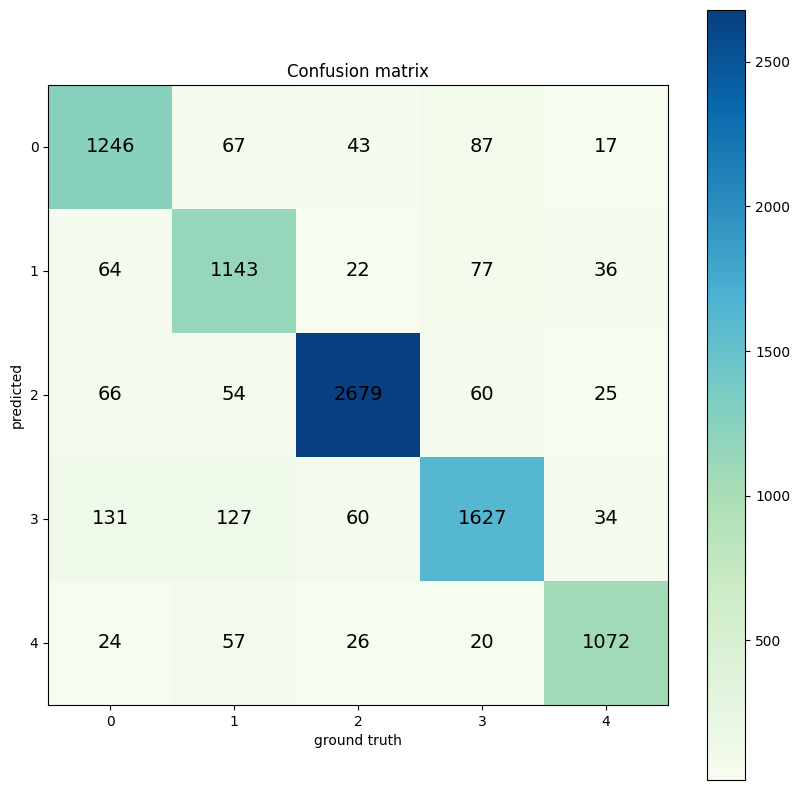

In [40]:
confusion_matrix = build_confusion_matrix(val_preds, val_gt,num_classes=5)
visualize_confusion_matrix(confusion_matrix)
print(dataset.class_to_idx)

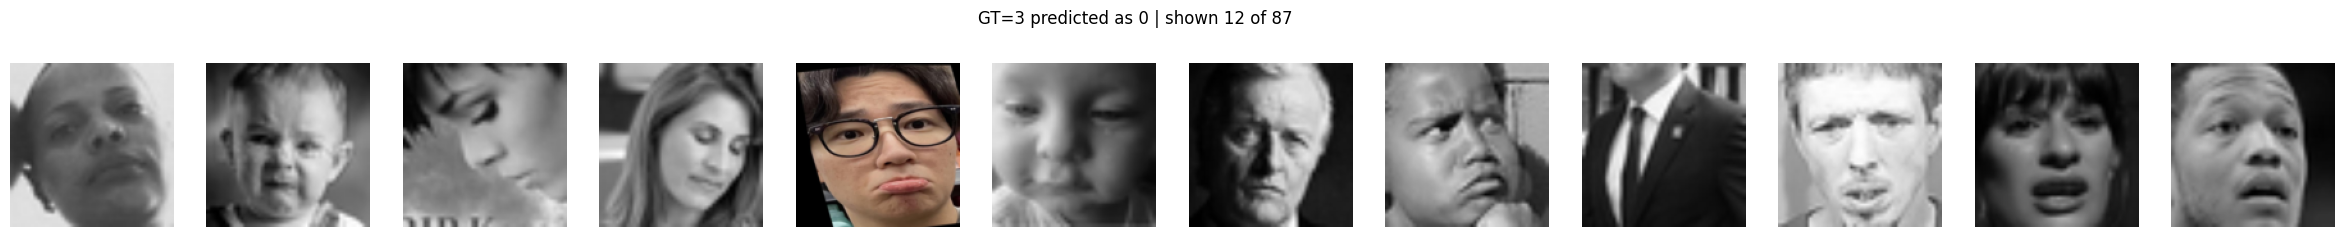

{'Angry': 0, 'Fear': 1, 'Happy': 2, 'Sad': 3, 'Suprise': 4}


In [39]:
visualize_predicted_actual_for_val(predicted_class=0, gt_class=3,
                                   predictions=val_preds, ground_truth=val_gt,
                                   val_dataset=val_dataset, max_num=12)
print(dataset.class_to_idx)

In [32]:
torch.save(model.state_dict(), "emotion_cnn.pth")